creating index...
index created!
Test:  [  0/548]  eta: 0:10:45  model_time: 0.9372 (0.9372)  evaluator_time: 0.0744 (0.0744)  time: 1.1784  data: 0.1616  max mem: 663
Test:  [100/548]  eta: 0:00:41  model_time: 0.0349 (0.0442)  evaluator_time: 0.0329 (0.0439)  time: 0.0736  data: 0.0021  max mem: 663
Test:  [200/548]  eta: 0:00:30  model_time: 0.0351 (0.0397)  evaluator_time: 0.0343 (0.0446)  time: 0.0862  data: 0.0024  max mem: 663
Test:  [300/548]  eta: 0:00:21  model_time: 0.0348 (0.0383)  evaluator_time: 0.0265 (0.0456)  time: 0.0681  data: 0.0025  max mem: 663
Test:  [400/548]  eta: 0:00:13  model_time: 0.0357 (0.0376)  evaluator_time: 0.0472 (0.0510)  time: 0.0884  data: 0.0025  max mem: 663
Test:  [500/548]  eta: 0:00:04  model_time: 0.0348 (0.0371)  evaluator_time: 0.0447 (0.0493)  time: 0.0849  data: 0.0024  max mem: 663
Test:  [547/548]  eta: 0:00:00  model_time: 0.0347 (0.0369)  evaluator_time: 0.0262 (0.0476)  time: 0.0643  data: 0.0023  max mem: 663
Test: Total time: 0:00


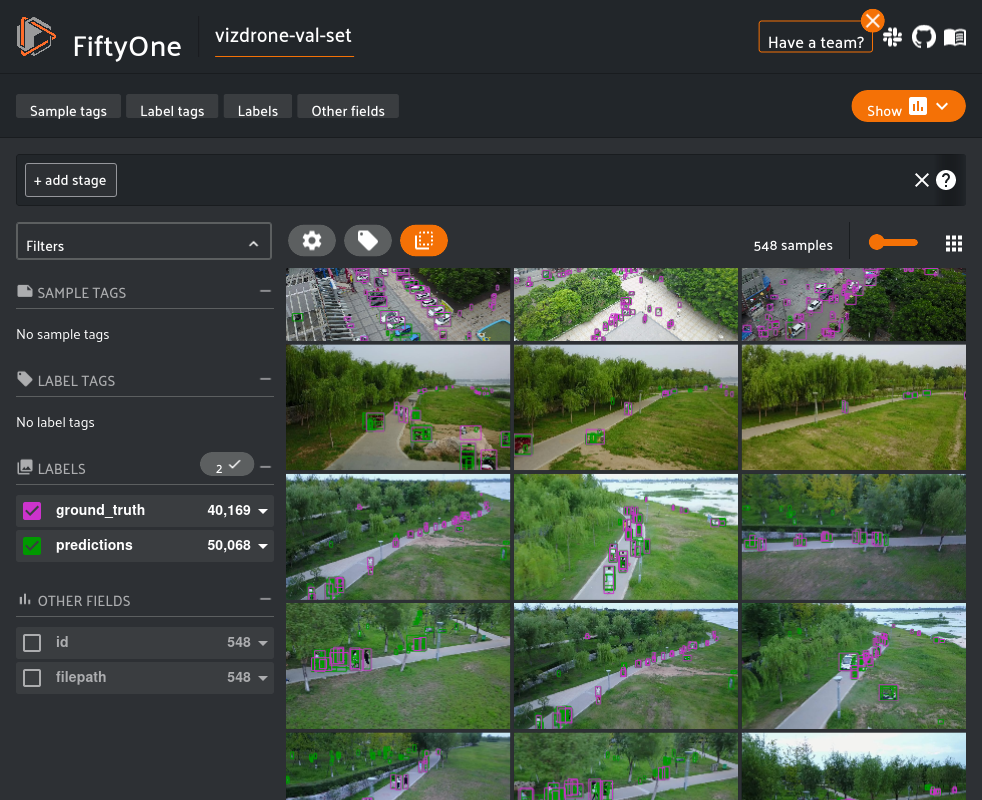

Notebook sessions cannot wait


In [1]:
import os
import sys
import torch
import torch.nn as nn

sys.path.append('../faster_rcnn_model/')
from train import evaluate, get_transform
from checkpoint import load_test_checkpoint
from train import get_faster_rcnn_model
import tensorboard_util as tb
from config import cfg
from dataloader import DetectionDataset


label_map = {
    0: 'ignored regions', 
    1: 'pedestrian',
    2: 'people',
    3: 'bicycle',
    4: 'car',
    5: 'van',
    6: 'truck',
    7: 'tricycle',
    8: 'awning-tricycle',
    9: 'bus',
    10: 'motor',
    11: 'others'
}

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

#load_test_checkpoint(cfg, model)

model = get_faster_rcnn_model(pretrained=False)
model.to(device)
model.eval()

dataset_test = DetectionDataset(cfg.DATA_DIR, 'val', transforms=get_transform(False))

data_loader = torch.utils.data.DataLoader(                      
         dataset_test, batch_size=cfg.TEST.BATCH_SIZE, shuffle=False, num_workers=4,
         collate_fn=dataset_test.collate_fn)

load_test_checkpoint(cfg, model)


evaluate(model, data_loader, device, writer=None)

from PIL import Image
from torchvision.transforms import functional as func

import fiftyone as fo



# Get class list
classes = label_map

dataset = fo.load_dataset('vizdrone-val-set')

transform = get_transform(False)

# Add predictions to samples
with fo.ProgressBar() as pb:
    for sample in pb(dataset):
        # Load image
        image = Image.open(sample.filepath).convert('RGB')
        img_tensor = func.to_tensor(image).to(device)
        c, h, w = img_tensor.shape


        image, _ = transform(image, target=None)
        #image = image.squeeze(1)

        # Perform inference
        preds = model([image.to(device)])
        labels = preds[0]["labels"].cpu().detach().numpy()
        scores = preds[0]["scores"].cpu().detach().numpy()
        boxes = preds[0]["boxes"].cpu().detach().numpy()

        # Convert detections to FiftyOne format
        detections = []
        for label, score, box in zip(labels, scores, boxes):
            # Convert to [top-left-x, top-left-y, width, height]
            # in relative coordinates in [0, 1] x [0, 1]
            x1, y1, x2, y2 = box
            rel_box = [x1 / w, y1 / h, (x2 - x1) / w, (y2 - y1) / h]

            detections.append(
                fo.Detection(
                    label=classes[label],
                    bounding_box=rel_box,
                    confidence=score
                )
            )

        # Save predictions to dataset
        sample["predictions"] = fo.Detections(detections=detections)
        sample.save()

session = fo.launch_app(dataset)

session.wait()

In [2]:
f = dataset.first()

In [12]:
f.predictions.detections[0]

<Detection: {
    'id': '619cc9ea5d10ccd4ca163171',
    'attributes': BaseDict({}),
    'tags': BaseList([]),
    'label': 'car',
    'bounding_box': BaseList([
        0.49327042897542317,
        0.5482369316948785,
        0.03414599100748698,
        0.08677243833188657,
    ]),
    'mask': None,
    'confidence': 0.9978129863739014,
    'index': None,
}>

In [9]:
from fiftyone import ViewField as F
predictions_view = dataset.take(100, seed=51)
high_conf_view = predictions_view.filter_labels("predictions", F("confidence") > 0.75)

In [10]:
high_conf_view

Dataset:     vizdrone-val-set
Media type:  image
Num samples: 100
Tags:        []
Sample fields:
    id:           fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.Metadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    predictions:  fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
View stages:
    1. Take(size=100, seed=51)
    2. FilterLabels(field='predictions', filter={'$gt': ['$$this.confidence', 0.75]}, only_matches=True, trajectories=False)

In [11]:
session.view = high_conf_view

In [14]:
results = high_conf_view.evaluate_detections(
    "predictions",
    gt_field="ground_truth",
    eval_key="eval",
    compute_mAP=True,
)

Evaluating detections...
 100% |█████████████████| 100/100 [8.1s elapsed, 0s remaining, 19.2 samples/s]      
Performing IoU sweep...
 100% |█████████████████| 100/100 [11.3s elapsed, 0s remaining, 15.9 samples/s]      


In [15]:
results.print_report()

                 precision    recall  f1-score   support

awning-tricycle       0.42      0.09      0.15       106
        bicycle       0.49      0.11      0.18       223
            bus       0.67      0.27      0.38        45
            car       0.90      0.63      0.74      2532
ignored regions       0.00      0.00      0.00       236
          motor       0.82      0.27      0.41       917
         others       0.00      0.00      0.00         5
     pedestrian       0.78      0.37      0.50      1666
         people       0.87      0.16      0.27       867
       tricycle       0.72      0.16      0.27       207
          truck       0.68      0.25      0.37       161
            van       0.68      0.28      0.40       393

      micro avg       0.84      0.38      0.53      7358
      macro avg       0.59      0.22      0.31      7358
   weighted avg       0.79      0.38      0.50      7358



In [16]:
results = dataset.evaluate_detections(
    "predictions",
    gt_field="ground_truth",
    eval_key="eval",
    compute_mAP=True,
)

Evaluating detections...
 100% |█████████████████| 548/548 [37.5s elapsed, 0s remaining, 19.3 samples/s]      
Performing IoU sweep...
 100% |█████████████████| 548/548 [1.6m elapsed, 0s remaining, 7.6 samples/s]       


In [17]:
results.print_report()

                 precision    recall  f1-score   support

awning-tricycle       0.15      0.37      0.21       532
        bicycle       0.15      0.28      0.19      1287
            bus       0.29      0.55      0.38       251
            car       0.69      0.79      0.74     14064
ignored regions       0.00      0.00      0.00      1378
          motor       0.45      0.53      0.49      4886
         others       0.04      0.22      0.06        32
     pedestrian       0.39      0.55      0.45      8844
         people       0.44      0.41      0.43      5125
       tricycle       0.28      0.38      0.32      1045
          truck       0.25      0.45      0.32       750
            van       0.30      0.57      0.40      1975

      micro avg       0.46      0.58      0.52     40169
      macro avg       0.29      0.42      0.33     40169
   weighted avg       0.47      0.58      0.52     40169



In [18]:
results.mAP()

0.17295456106402315

In [24]:
plot = results.plot_pr_curves()
plot.show()

FigureWidget({
    'data': [{'hovertemplate': '<b>class: %{text}</b><br>recall: %{x}<br>precision: %{y}<extra>…

In [26]:
# Get the 10 most common classes in the dataset
counts = dataset.count_values("ground_truth.detections.label")
classes = sorted(counts, key=counts.get, reverse=True)[:10]

# Print a classification report for the top-10 classes
results.print_report(classes=classes)

                 precision    recall  f1-score   support

            car       0.69      0.79      0.74     14064
     pedestrian       0.39      0.55      0.45      8844
         people       0.44      0.41      0.43      5125
          motor       0.45      0.53      0.49      4886
            van       0.30      0.57      0.40      1975
ignored regions       0.00      0.00      0.00      1378
        bicycle       0.15      0.28      0.19      1287
       tricycle       0.28      0.38      0.32      1045
          truck       0.25      0.45      0.32       750
awning-tricycle       0.15      0.37      0.21       532

      micro avg       0.47      0.58      0.52     39886
      macro avg       0.31      0.43      0.35     39886
   weighted avg       0.48      0.58      0.52     39886



In [28]:
results = dataset.evaluate_detections(
    "predictions",
    gt_field="ground_truth",
    eval_key="eval_predictions",
)

Evaluating detections...
 100% |█████████████████| 548/548 [43.3s elapsed, 0s remaining, 17.3 samples/s]      


In [31]:
results = dataset.evaluate_detections(
    "predictions", gt_field="ground_truth", classwise=False
)

# Generate a confusion matrix for the specified classes
plot = results.plot_confusion_matrix(classes=["car", "truck", "motorcycle"])
plot.show()

Evaluating detections...
 100% |█████████████████| 548/548 [1.2m elapsed, 0s remaining, 9.7 samples/s]       


TypeError: 10864 is not JSON serializable

In [32]:
# Generate a confusion matrix for the specified classes
plot = results.plot_confusion_matrix()
plot.show()

TypeError: 10864 is not JSON serializable